In [1]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib
from IPython.display import HTML

import torch
import torch.nn as nn
import torch.nn.functional as F

from src.CNN import advCNNActionValue

import src.DDQN as DDQN
from src.Preprocess import preprocess, ImageEnv
from src.setPenaltyAndPreprocess import setPenaltyAndPreprocess

In [2]:
env = gym.make('CarRacing-v2', continuous=False)
print("Observation space: ", env.observation_space)
print("Action space: ", env.action_space)

Observation space:  Box(0, 255, (96, 96, 3), uint8)
Action space:  Discrete(5)


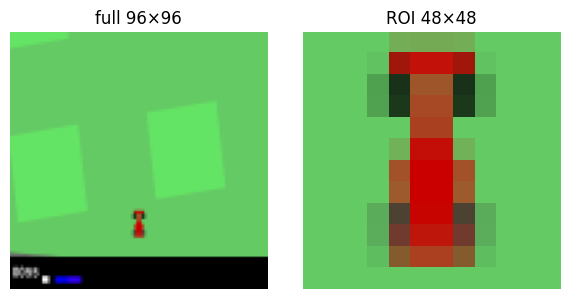

In [3]:

env = gym.make('CarRacing-v2', continuous=False)
s, _ = env.reset() 


# 가속 액션(디스크리트: 3번) 15프레임 정도 미리 돌려 줌
for _ in range(130):
    obs, _, _, _, _ = env.step(3)      # 3 = gas


# 2) 관심 구역(ROI) 좌표 정의  ─ 여기선 화면 중심 48×48
cx, cy = 48, 72      # 차가 중앙에 오므로 중심
r = 6                # 반경 24 → 48픽셀 정사각형 양 옆은 3정도 고정 자동차 좌표 = 48, 72 앞의 거리 -> 66 + 6 가로세로 12
roi = obs[cy-r:cy+r, cx-r:cx+r]       # (48, 48, 3)

# 3) 시각화: 전체 프레임 & ROI 나란히 보기
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1); plt.imshow(obs); plt.title("full 96×96"); plt.axis("off")
plt.subplot(1, 2, 2); plt.imshow(roi); plt.title("ROI 48×48");  plt.axis("off")
plt.tight_layout(); plt.show()


0


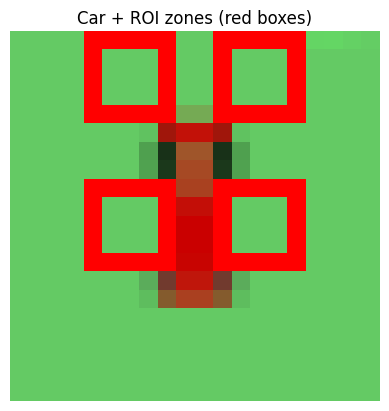

In [4]:
# 2) 차 중심 기준 ROI 좌표 설정
import cv2

def is_gray(rgb, thr=20):
    """RGB 평균이 거의 같은 경우 → 회색으로 간주"""
    r, g, b = rgb
    return abs(r - g) < thr and abs(g - b) < thr and abs(r - b) < thr

cx, cy = 48, 72   # 자동차 중심 (CarRacing 규격 고정)
roi_size = 4      # ROI 한 변 (6x6 픽셀)

# ROI 위치 목록 (왼쪽 측면, 오른쪽 측면, 전방 왼쪽, 전방 오른쪽)
rois = [
    (cx - 4, cy),         # 왼쪽 측면
    (cx + 3, cy),         # 오른쪽 측면
    (cx - 4, cy - 8),      # 전방 왼쪽
    (cx + 3, cy - 8),      # 전방 오른쪽
]

# 3) 시각화를 위해 복사 (원본 손상 방지)
obs_viz = obs.copy()

count = 0
# 4) ROI를 사각형으로 표시
for (x, y) in rois:
    x1, y1 = x - roi_size//2, y - roi_size//2
    x2, y2 = x + roi_size//2, y + roi_size//2
                

    roi = obs[y - roi_size//2: y + roi_size//2,
                      x - roi_size//2:x + roi_size//2]            
    mean_color = roi.mean(axis=(0, 1))  # RGB 평균

    # 회색이 아니면 페널티
    if is_gray(mean_color):
        count += 1
        
    # 빨간 사각형 그리기 (BGR로 변환 후 그려야 색이 맞음
    obs_viz = cv2.rectangle(obs_viz, (x1, y1), (x2, y2), (255, 0, 0), 1)

print(count)

r= 10
obs_viz = obs_viz[cy-r:cy+r, cx-r:cx+r]  
# 5) RGB로 변환 후 출력
plt.imshow(obs_viz)
plt.title("Car + ROI zones (red boxes)")
plt.axis("off")
plt.show()

env.close()

In [5]:
#훈련시에만 적용  게임 이미지 -> reward wrapper -> resizing
env = gym.make('CarRacing-v2', continuous=False)
env = setPenaltyAndPreprocess(env, penalty=0.1)  

max_steps = int(1e5)
eval_interval = 1000
state_dim = (4, 84, 84)
action_dim = env.action_space.n

agent = DDQN.DDQN(state_dim, action_dim, target_update_interval=5000)

cuda


In [6]:
def evaluate(n_evals=3):
    eval_env = gym.make('CarRacing-v2', continuous=False)
    eval_env = ImageEnv(eval_env)
    
    scores = 0
    for i in range(n_evals):
        (s, _), done, ret = eval_env.reset(), False, 0
        while not done:
            a = agent.act(s, training=False)
            s_prime, r, terminated, truncated, info = eval_env.step(a)
            s = s_prime
            ret += r
            done = terminated or truncated
        scores += ret
    return np.round(scores / n_evals, 4)

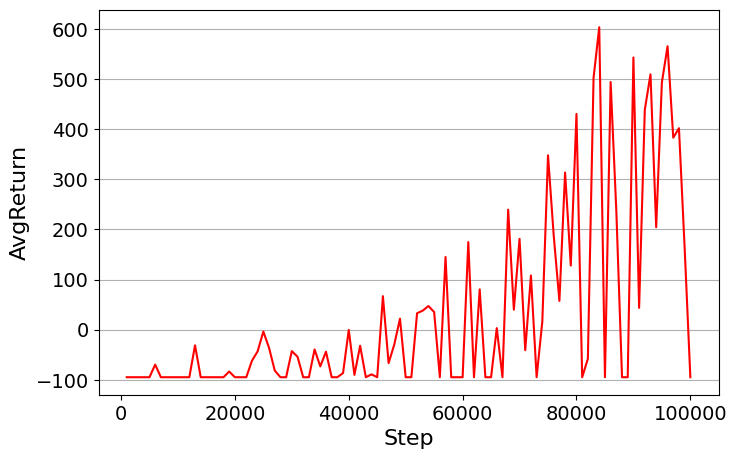

In [7]:
from IPython.display import clear_output

history = {'Step': [], 'AvgReturn': []}
loss_history = {'total_steps': [], 'value_loss': []}

(s, _) = env.reset()

while True:
    a = agent.act(s)
    s_prime, r, terminated, truncated, info = env.step(a)
    result = agent.process((s, a, r, s_prime, terminated))  # You can track q-losses over training from `result` variable.
    
    if result: #warm up 단계일 경우 x 
        loss_history['total_steps'].append(result['total_steps'])
        loss_history['value_loss'].append(result['value_loss'])
    s = s_prime
    if terminated or truncated:
        s, _ = env.reset()
        
    if agent.total_steps % eval_interval == 0:
        ret = evaluate()
        history['Step'].append(agent.total_steps)
        history['AvgReturn'].append(ret)
        
        clear_output()
        plt.figure(figsize=(8, 5))
        plt.plot(history['Step'], history['AvgReturn'], 'r-')
        plt.xlabel('Step', fontsize=16)
        plt.ylabel('AvgReturn', fontsize=16)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.grid(axis='y')
        plt.show()
        
        #torch.save(agent.network.state_dict(), 'dqn.pt')
    
    if agent.total_steps > max_steps:
        break

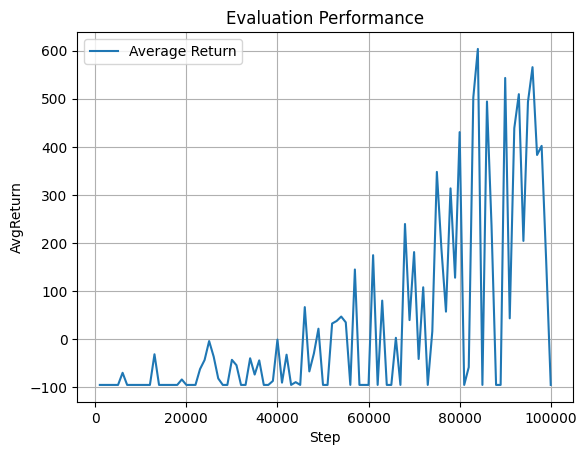

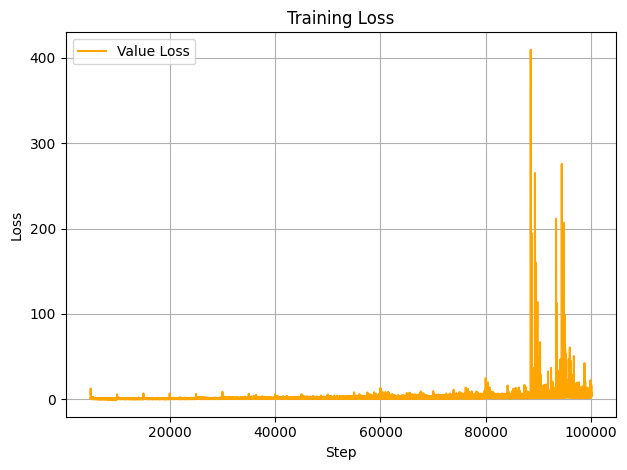

In [8]:
# 평균 리턴 그래프
plt.plot(history['Step'], history['AvgReturn'], label='Average Return')
plt.xlabel('Step')
plt.ylabel('AvgReturn')
plt.title('Evaluation Performance')
plt.grid(True)
plt.legend()
plt.show()
# Loss 그래프
plt.plot(loss_history['total_steps'], loss_history['value_loss'], label='Value Loss', color='orange')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()

# 화면에 표시
plt.show()

In [14]:
eval_env = gym.make('CarRacing-v2', continuous=False, render_mode='rgb_array')
eval_env = ImageEnv(eval_env)

frames = []
scores = 0
(s, _), done, ret = eval_env.reset(), False, 0
while not done:
    frames.append(eval_env.render())
    a = agent.act(s, training=False)
    s_prime, r, terminated, truncated, info = eval_env.step(a)
    s = s_prime
    ret += r
    done = terminated or truncated
scores += ret


print(scores)

-94.99999999999898


In [10]:
import pickle

# 저장
with open("data/DDQNEi_history.pkl", "wb") as f:
    pickle.dump(history, f)

with open("data/DDQNEi_loss_history.pkl", "wb") as f:
    pickle.dump(loss_history, f)

torch.save(agent.network.state_dict(), 'data/DDQNEi_dqn.pt')


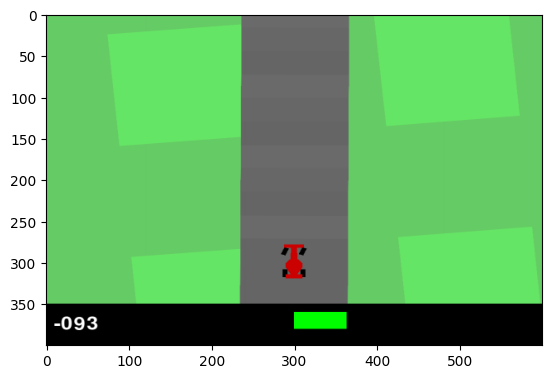

In [11]:
import matplotlib.animation as animation
fig = plt.figure()
ims = []

for frame in frames:
    im = plt.imshow(frame, animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True)

# 애니메이션을 저장
ani.save('DDQNse_car_racing_result.gif', writer='pillow')

plt.show()

In [12]:
score_h= []
for i in range(20):
    eval_env = gym.make('CarRacing-v2', continuous=False, render_mode='rgb_array')
    eval_env = ImageEnv(eval_env)

    frames = []
    scores = 0
    (s, _), done, ret = eval_env.reset(), False, 0
    while not done:
        frames.append(eval_env.render())
        a = agent.act(s, training=False)
        s_prime, r, terminated, truncated, info = eval_env.step(a)
        s = s_prime
        ret += r
        done = terminated or truncated
    scores += ret

    score_h.append(scores)

print(score_h)


[-94.99999999999898, -94.99999999999895, -94.99999999999898, 461.0165975103613, -94.99999999999898, -94.99999999999898, -94.99999999999895, -94.99999999999898, -94.99999999999896, 60.47703180212449, -94.99999999999898, -94.999999999999, -94.999999999999, -94.99999999999903, -94.99999999999898, 632.272727272713, 462.1428571428444, -94.99999999999895, -94.99999999999898, -94.999999999999]


In [13]:
# 평균 계산
import csv
mean_score = np.mean(score_h)
std_score = np.std(score_h)

max_score = np.max(score_h)
min_score = np.min(score_h)
print("평균 Return:", mean_score)
print("표준편차:", std_score)
print("max return:", max_score)
print("min return:", min_score)

# 저장하기
with open("./data/DDQN_result.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Method", "Value"])
    writer.writerow(["Mean", mean_score])
    writer.writerow(["Std", std_score])
    writer.writerow(["Max", max_score])
    writer.writerow(["Min", min_score])

평균 Return: 4.795460686402974
표준편차: 220.62169745434738
max return: 632.272727272713
min return: -94.99999999999903
